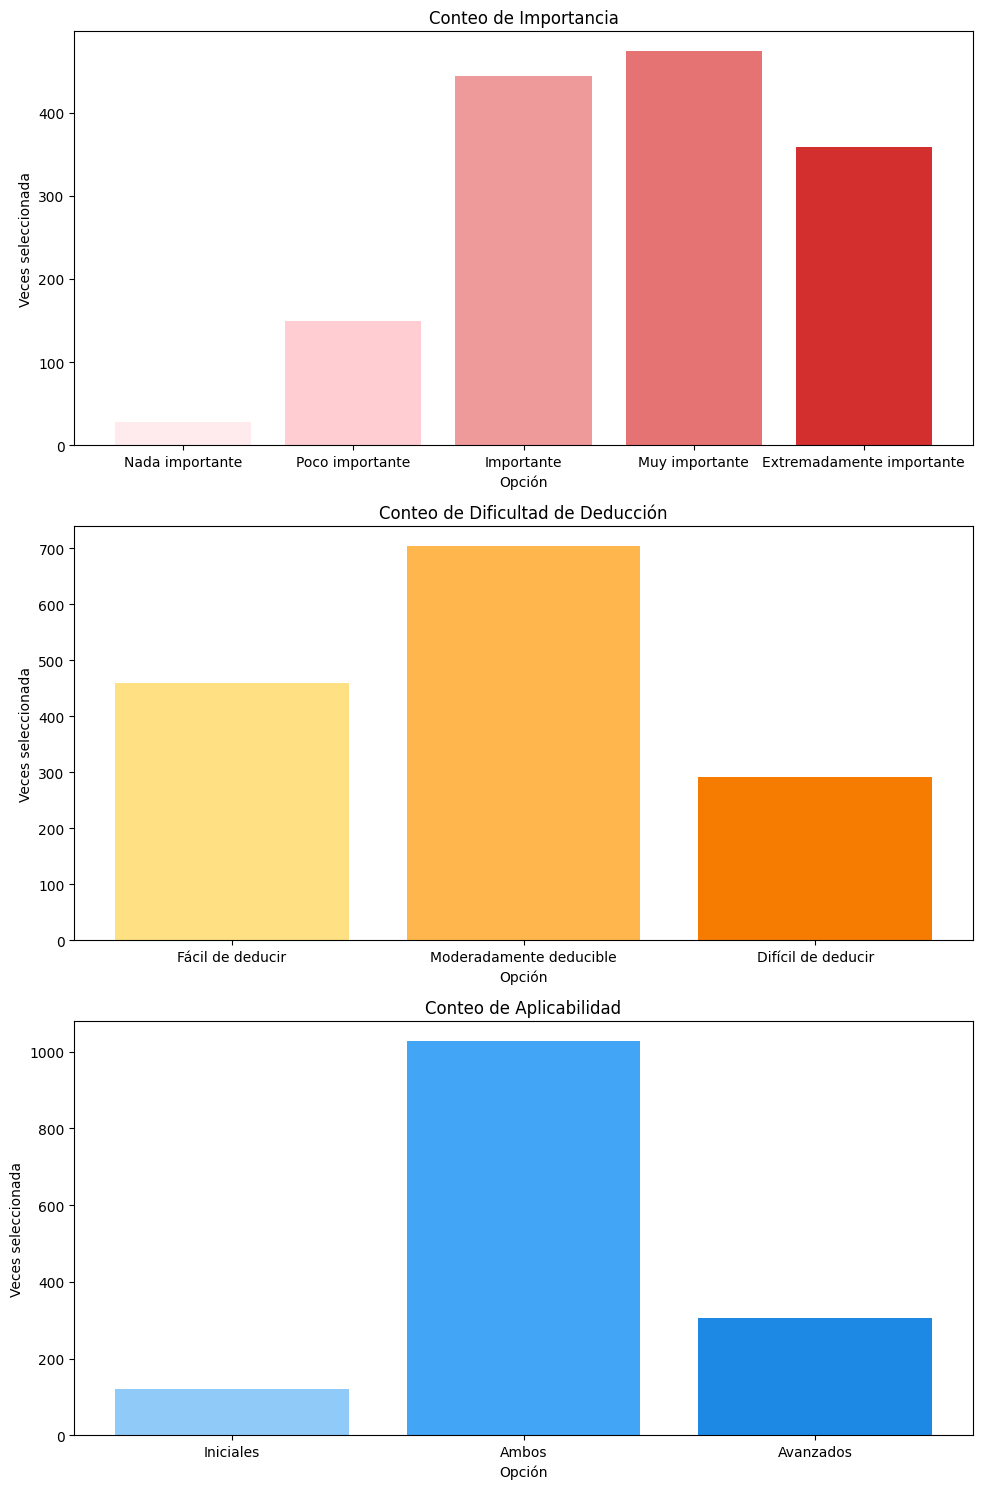

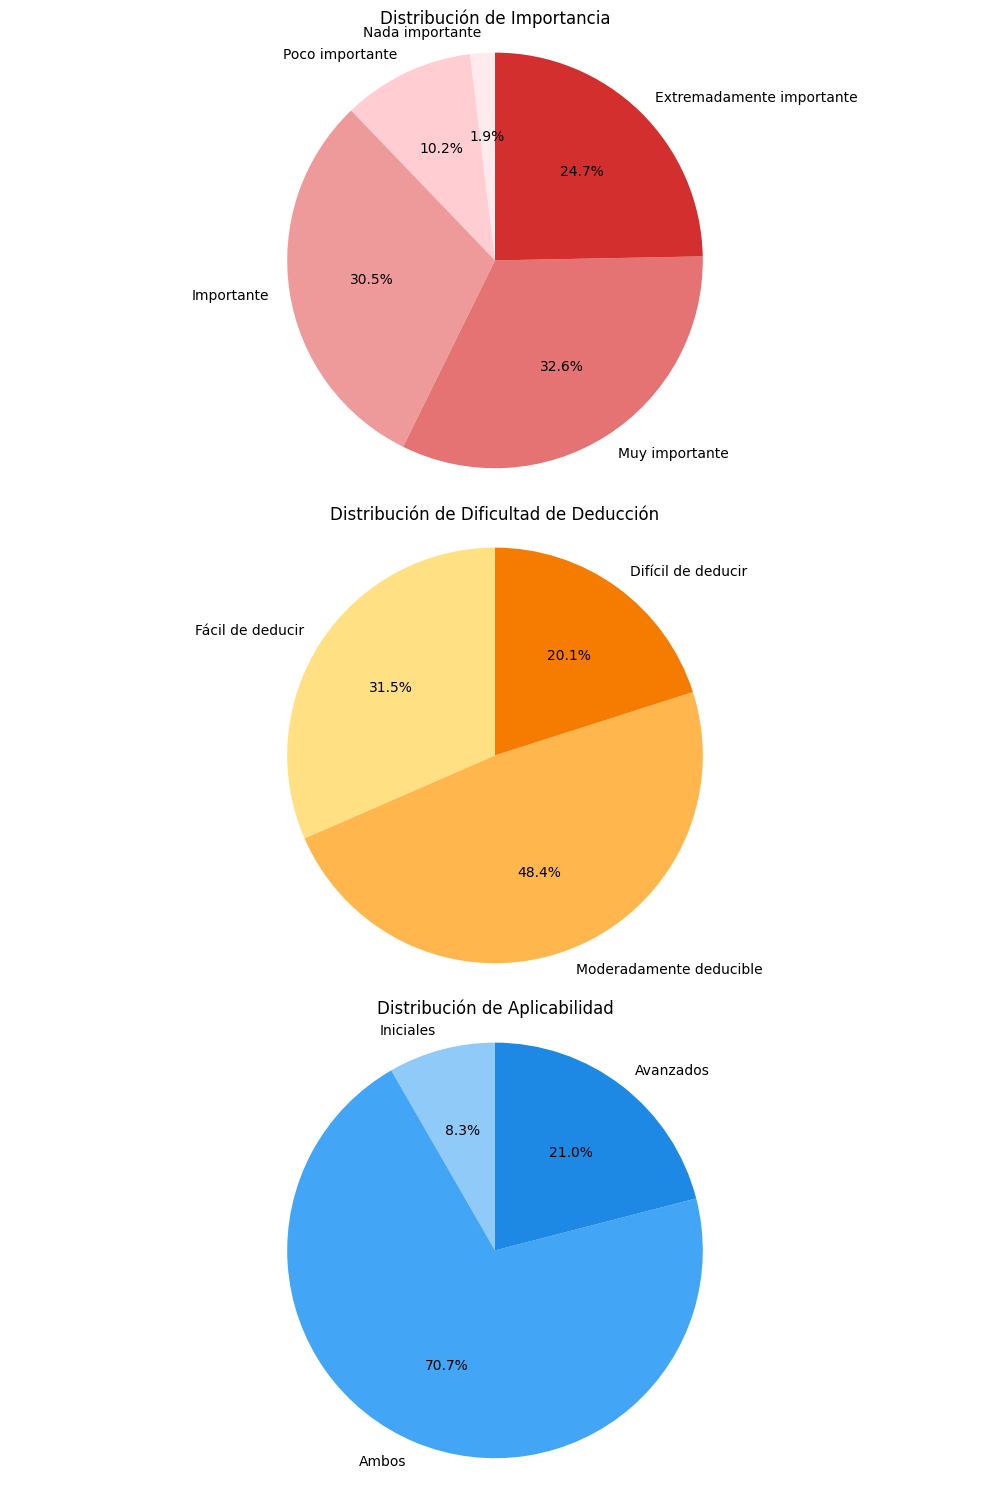

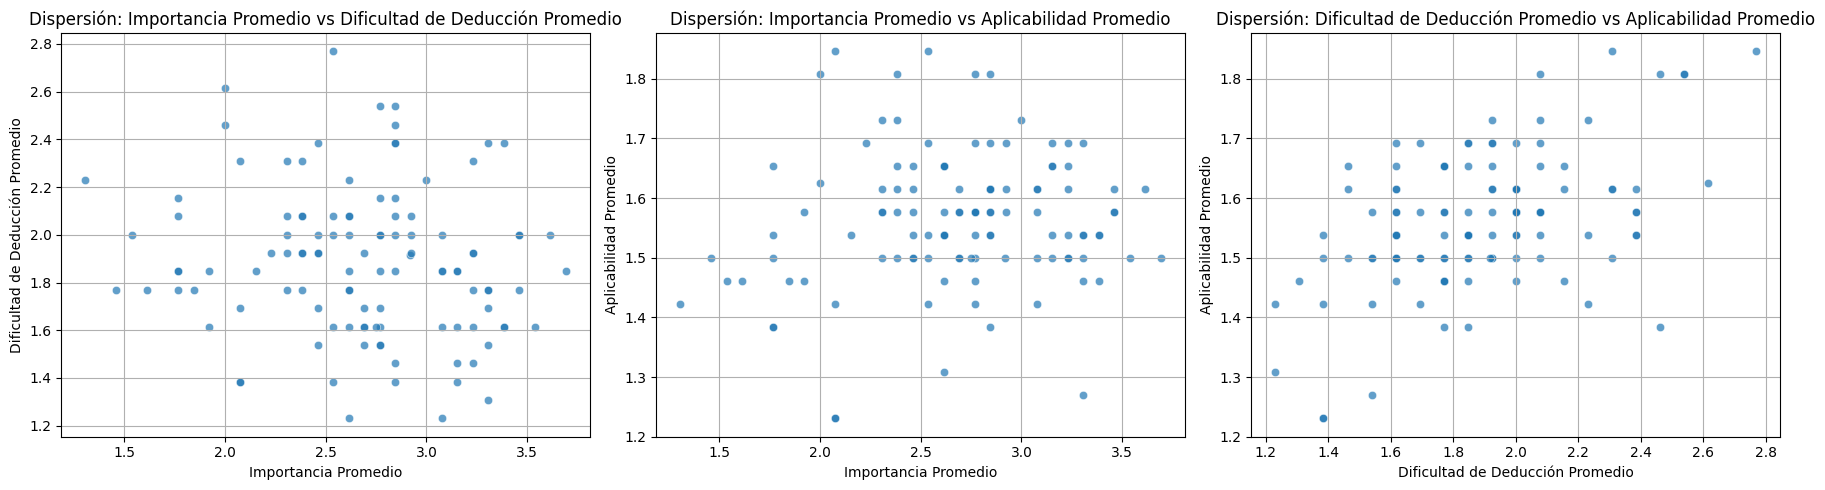

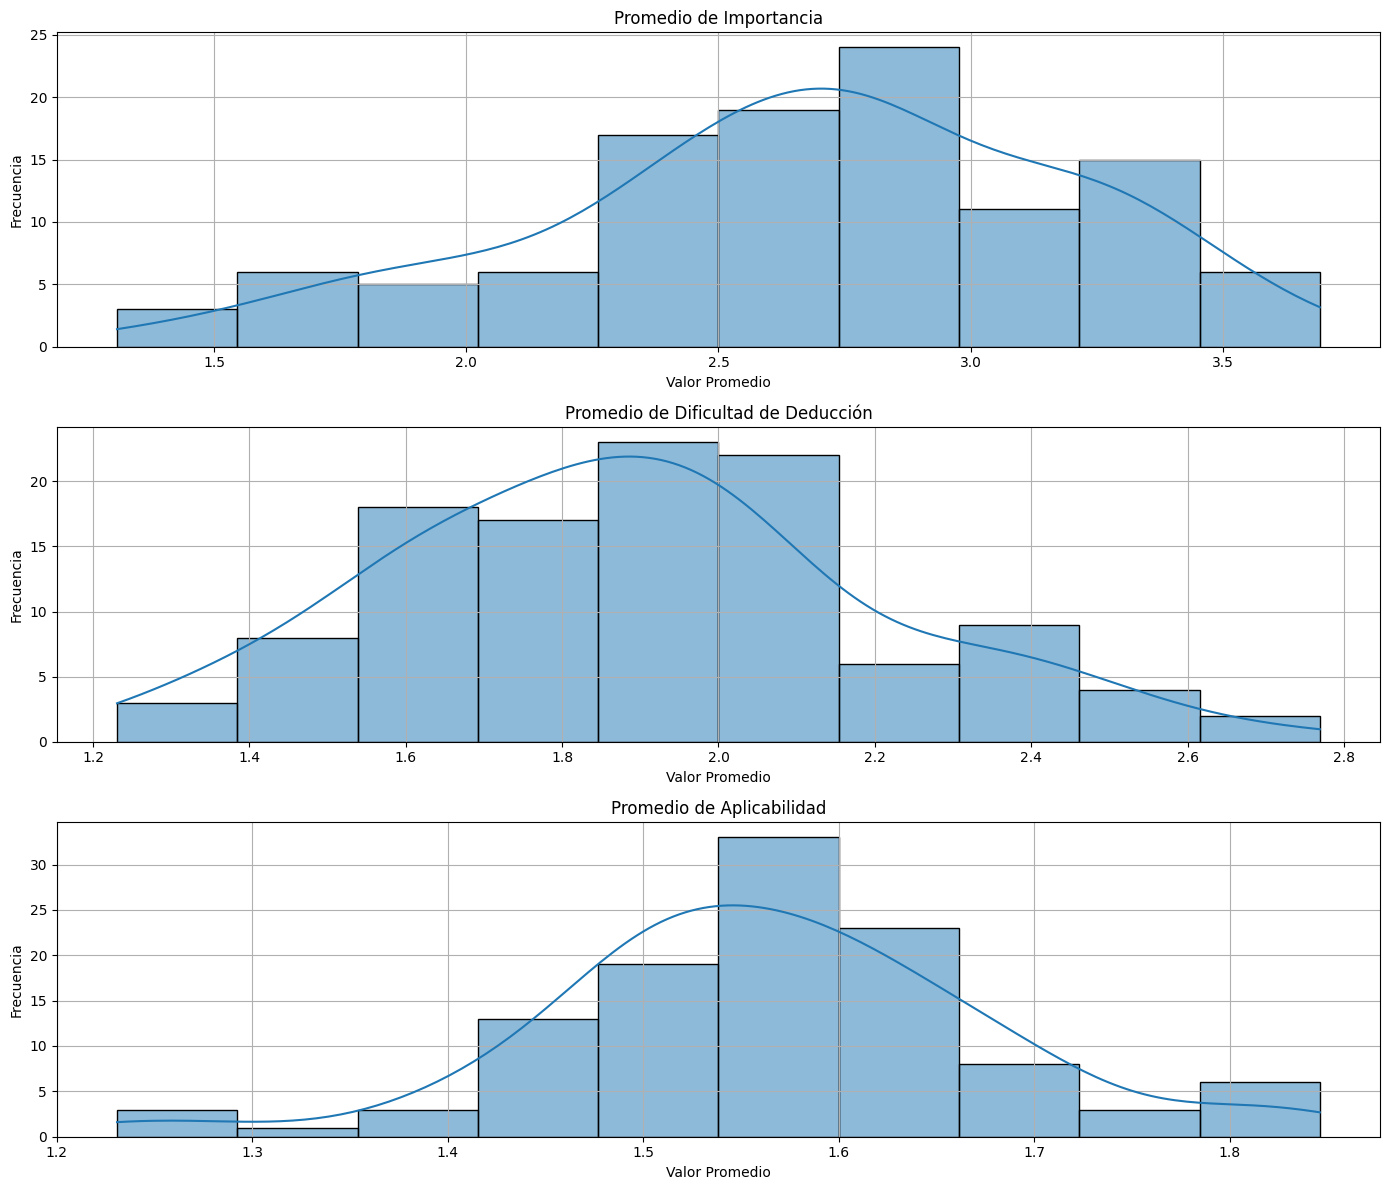

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import os

# 📌 Diccionario de colores fijos para cada opción (y orden)
COLOR_MAP = {
    # Aplicable a (Tonos de azul)
    "Iniciales": "#90CAF9",
    "Ambos": "#42A5F5",
    "Avanzados": "#1E88E5",
    # Importancia (Tonos de rojo)
    "Nada importante": "#FFEBEE",
    "Poco importante": "#FFCDD2",
    "Importante": "#EF9A9A",
    "Muy importante": "#E57373",
    "Extremadamente importante": "#D32F2F",
    # Dificultad de deducción (Tonos de naranja)
    "Fácil de deducir": "#FFE082",
    "Moderadamente deducible": "#FFB74D",
    "Difícil de deducir": "#F57C00",
}

# 📁 Función para cargar los CSVs desde la carpeta 'encuestas'
def load_data(folder='encuestas'):
    data = {}
    for file in os.listdir(folder):
        if file.endswith('.csv'):
            path = os.path.join(folder, file)
            df = pd.read_csv(path, encoding='utf-8')
            data[file.replace('.csv', '')] = df
    return data

# ⚙️ Función para preparar los datos sin eliminar duplicados
def prepare_data(data):
    """
    Concatena todos los CSV y filtra solo las filas de consejos 
    (donde la columna '#' es numérica). Se retorna el DataFrame completo
    para que al graficar se tomen en cuenta todos los votos.
    """
    all_data_full = pd.concat(data.values(), ignore_index=True)
    # Filtrar solo filas cuyo valor en '#' sea numérico (los consejos)
    advice_data = all_data_full[all_data_full['#'].astype(str).str.isdigit()].copy()
    
    # Opcional: Mapear valores a números (útil para otros análisis)
    importance_map = {"Nada importante": 0, "Poco importante": 1, "Importante": 2, "Muy importante": 3, "Extremadamente importante": 4}
    difficulty_map = {"Fácil de deducir": 1, "Moderadamente deducible": 2, "Difícil de deducir": 3}
    applicable_map = {"Iniciales": 1, "Ambos": 1.5, "Avanzados": 2}
    
    advice_data['Importancia Valor'] = advice_data['Importancia'].map(importance_map)
    advice_data['Dificultad Valor'] = advice_data['Dificultad de Deducción'].map(difficulty_map)
    advice_data['Aplicable Valor'] = advice_data['Aplicable a'].map(applicable_map)
    
    return advice_data

# 📌 Función para calcular promedios y conteo detallado por categoría
def calculate_aggregated_data(advice_data):
    """
    Calcula los promedios de Importancia, Dificultad de Deducción y Aplicabilidad,
    y también cuenta cuántas veces se seleccionó cada opción en cada categoría.
    """
    # Calcular promedios
    aggregated_data = advice_data.groupby('#')[['Importancia Valor', 'Dificultad Valor', 'Aplicable Valor']].agg(['mean', 'count']).reset_index()
    
    # Renombrar columnas para claridad
    aggregated_data.columns = ['#', 
                               'Importancia Promedio', 'Importancia Conteo',
                               'Dificultad de Deducción Promedio', 'Dificultad de Deducción Conteo',
                               'Aplicabilidad Promedio', 'Aplicabilidad Conteo']

    # Contar ocurrencias de cada opción en cada categoría
    importance_counts = advice_data.groupby('#')['Importancia'].value_counts().unstack(fill_value=0)
    difficulty_counts = advice_data.groupby('#')['Dificultad de Deducción'].value_counts().unstack(fill_value=0)
    applicable_counts = advice_data.groupby('#')['Aplicable a'].value_counts().unstack(fill_value=0)

    # Fusionar las tablas de conteo con los promedios y conteos totales
    aggregated_data = aggregated_data.merge(importance_counts, on='#', how='left')
    aggregated_data = aggregated_data.merge(difficulty_counts, on='#', how='left')
    aggregated_data = aggregated_data.merge(applicable_counts, on='#', how='left')

    # Reemplazar NaN por 0 en los conteos
    aggregated_data.fillna(0, inplace=True)

    return aggregated_data

# 📌 Función para graficar dispersión en pares de dimensiones con promedios
def plot_scatter_pairs(aggregated_data):
    """
    Genera gráficos de dispersión en 2D para todas las combinaciones de dimensiones usando los promedios:
    - Importancia Promedio vs Dificultad de Deducción Promedio
    - Importancia Promedio vs Aplicabilidad Promedio
    - Dificultad de Deducción Promedio vs Aplicabilidad Promedio
    """
    pairs = [
        ('Importancia Promedio', 'Dificultad de Deducción Promedio'),
        ('Importancia Promedio', 'Aplicabilidad Promedio'),
        ('Dificultad de Deducción Promedio', 'Aplicabilidad Promedio')
    ]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, (x, y) in enumerate(pairs):
        sns.scatterplot(data=aggregated_data, x=x, y=y, ax=axes[i], alpha=0.7)
        axes[i].set_title(f'Dispersión: {x} vs {y}')
        axes[i].set_xlabel(x)
        axes[i].set_ylabel(y)
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# 📌 Función para graficar histogramas del conteo total y el promedio en cada categoría
def plot_histograms(aggregated_data):
    """
    Genera histogramas de la cantidad de votos y del promedio en cada categoría.
    """
    categories = ['Importancia', 'Dificultad de Deducción', 'Aplicabilidad']
    count_columns = ['Importancia Conteo', 'Dificultad de Deducción Conteo', 'Aplicabilidad Conteo']
    mean_columns = ['Importancia Promedio', 'Dificultad de Deducción Promedio', 'Aplicabilidad Promedio']
    titles = ['Importancia', 'Dificultad de Deducción', 'Aplicabilidad']

    fig, axes = plt.subplots(3, 1, figsize=(14, 12))

    for i in range(3):
        # Histograma de promedios
        sns.histplot(aggregated_data[mean_columns[i]], bins=10, kde=True, ax=axes[i])
        axes[i].set_title(f'Promedio de {titles[i]}')
        axes[i].set_xlabel('Valor Promedio')
        axes[i].set_ylabel('Frecuencia')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# 📌 Función para graficar histogramas del conteo de cada categoría
def plot_category_counts(advice_data):
    """
    Genera gráficos de barras en tres filas que muestran cuántas veces se seleccionó cada opción
    en las categorías 'Importancia', 'Dificultad de Deducción' y 'Aplicable a'.
    """
    # Opciones definidas para mantener el orden
    importance_options = ["Nada importante", "Poco importante", "Importante", "Muy importante", "Extremadamente importante"]
    difficulty_options = ["Fácil de deducir", "Moderadamente deducible", "Difícil de deducir"]
    applicable_options = ["Iniciales", "Ambos", "Avanzados"]

    # Calcular los conteos a partir del DataFrame completo (advice_data)
    imp_counts = advice_data['Importancia'].value_counts().reindex(importance_options, fill_value=0)
    diff_counts = advice_data['Dificultad de Deducción'].value_counts().reindex(difficulty_options, fill_value=0)
    appl_counts = advice_data['Aplicable a'].value_counts().reindex(applicable_options, fill_value=0)

    # Crear subplots para las tres categorías en filas (3 filas, 1 columna)
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))

    # Gráfico para Importancia
    axes[0].bar(imp_counts.index, imp_counts.values, color=[COLOR_MAP[x] for x in imp_counts.index])
    axes[0].set_title("Conteo de Importancia")
    axes[0].set_xlabel("Opción")
    axes[0].set_ylabel("Veces seleccionada")

    # Gráfico para Dificultad de Deducción
    axes[1].bar(diff_counts.index, diff_counts.values, color=[COLOR_MAP[x] for x in diff_counts.index])
    axes[1].set_title("Conteo de Dificultad de Deducción")
    axes[1].set_xlabel("Opción")
    axes[1].set_ylabel("Veces seleccionada")

    # Gráfico para Aplicable a
    axes[2].bar(appl_counts.index, appl_counts.values, color=[COLOR_MAP[x] for x in appl_counts.index])
    axes[2].set_title("Conteo de Aplicabilidad")
    axes[2].set_xlabel("Opción")
    axes[2].set_ylabel("Veces seleccionada")

    plt.tight_layout()
    plt.show()

# ─────────────────────────────
# NUEVA FUNCIÓN: Gráficos de Torta por Categoría
# ─────────────────────────────
def plot_category_pie_charts(advice_data):
    """
    Genera gráficos de torta en tres filas que muestran la distribución (porcentaje)
    de cada opción en las categorías 'Importancia', 'Dificultad de Deducción' y 'Aplicable a'.
    """
    # Definir las opciones en el orden deseado
    importance_options = ["Nada importante", "Poco importante", "Importante", "Muy importante", "Extremadamente importante"]
    difficulty_options = ["Fácil de deducir", "Moderadamente deducible", "Difícil de deducir"]
    applicable_options = ["Iniciales", "Ambos", "Avanzados"]

    # Calcular los conteos para cada categoría
    imp_counts = advice_data['Importancia'].value_counts().reindex(importance_options, fill_value=0)
    diff_counts = advice_data['Dificultad de Deducción'].value_counts().reindex(difficulty_options, fill_value=0)
    appl_counts = advice_data['Aplicable a'].value_counts().reindex(applicable_options, fill_value=0)

    # Crear subplots: 3 filas, 1 columna
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))

    # Pie chart para Importancia
    axes[0].pie(imp_counts.values, labels=imp_counts.index, autopct='%1.1f%%', startangle=90,
                colors=[COLOR_MAP[x] for x in imp_counts.index])
    axes[0].axis('equal')
    axes[0].set_title("Distribución de Importancia")

    # Pie chart para Dificultad de Deducción
    axes[1].pie(diff_counts.values, labels=diff_counts.index, autopct='%1.1f%%', startangle=90,
                colors=[COLOR_MAP[x] for x in diff_counts.index])
    axes[1].axis('equal')
    axes[1].set_title("Distribución de Dificultad de Deducción")

    # Pie chart para Aplicable a
    axes[2].pie(appl_counts.values, labels=appl_counts.index, autopct='%1.1f%%', startangle=90,
                colors=[COLOR_MAP[x] for x in appl_counts.index])
    axes[2].axis('equal')
    axes[2].set_title("Distribución de Aplicabilidad")

    plt.tight_layout()
    plt.show()

# ─────────────────────────────
# Funciones para graficar (Torta/Histogramas por Consejo)
# ─────────────────────────────
def plot_pie_charts(advice_data):
    """
    Para el gráfico general se muestra la distribución de todas las respuestas
    usando histogramas en lugar de gráficos de torta.
    """
    plot_category_pie_charts(advice_data)

def plot_pie_charts_per_advice(advice_data):
    """
    Genera gráficos (torta) para cada consejo (filtrado por la columna '#') 
    utilizando todos los votos de ese consejo.
    """
    advice_data_reset = advice_data.reset_index(drop=True)
    processed_advices = set()

    for _, row in advice_data_reset.iterrows():
        consejo_num = str(row['#'])
        if consejo_num in processed_advices:
            continue
        processed_advices.add(consejo_num)

        if pd.notna(row.get('Práctica')) and row.get('Práctica') != "":
            title = f"Consejo {consejo_num}"
            consejo_text = row['Práctica']
            consejo_data = advice_data_reset[advice_data_reset['#'] == row['#']]
            plot_category_pie_charts(consejo_data)

# ─────────────────────────────
# Ejemplo de uso:
# ─────────────────────────────
data = load_data()                     # Carga los CSVs desde la carpeta 'encuestas'
advice_data = prepare_data(data)         # Prepara el DataFrame completo con todas las respuestas

plot_category_counts(advice_data)        # Gráficos de barras (conteo) por categoría
plot_category_pie_charts(advice_data)    # Gráficos de torta
advice_data_agg = calculate_aggregated_data(advice_data)
plot_scatter_pairs(advice_data_agg)        # Gráficos de dispersión de promedios
plot_histograms(advice_data_agg)           # Histogramas de promedios por categoría
